Used 23 years stock price data for JPMC from Yahoo Finance
USed LSTM Autoencoding to detect anomalies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## load dataset

data = pd.read_csv('JPM.csv', usecols=['Date','Open'])
data.head()

,Date,Open
0,2000-01-03,49.833332
1,2000-01-04,47.083332
2,2000-01-05,46.833332
3,2000-01-06,46.750000
4,2000-01-07,48.416668


In [3]:
## null value check

data.isnull().sum()

Date    0
Open    0
dtype: int64

In [4]:
## convert 'Date'--> datetime and set as index

data['Date'] = data['Date'].apply(lambda str_date: pd.to_datetime(str_date))

data.set_index('Date', inplace=True)

data.head()

,Open
Date,
2000-01-03,49.833332
2000-01-04,47.083332
2000-01-05,46.833332
2000-01-06,46.750000
2000-01-07,48.416668


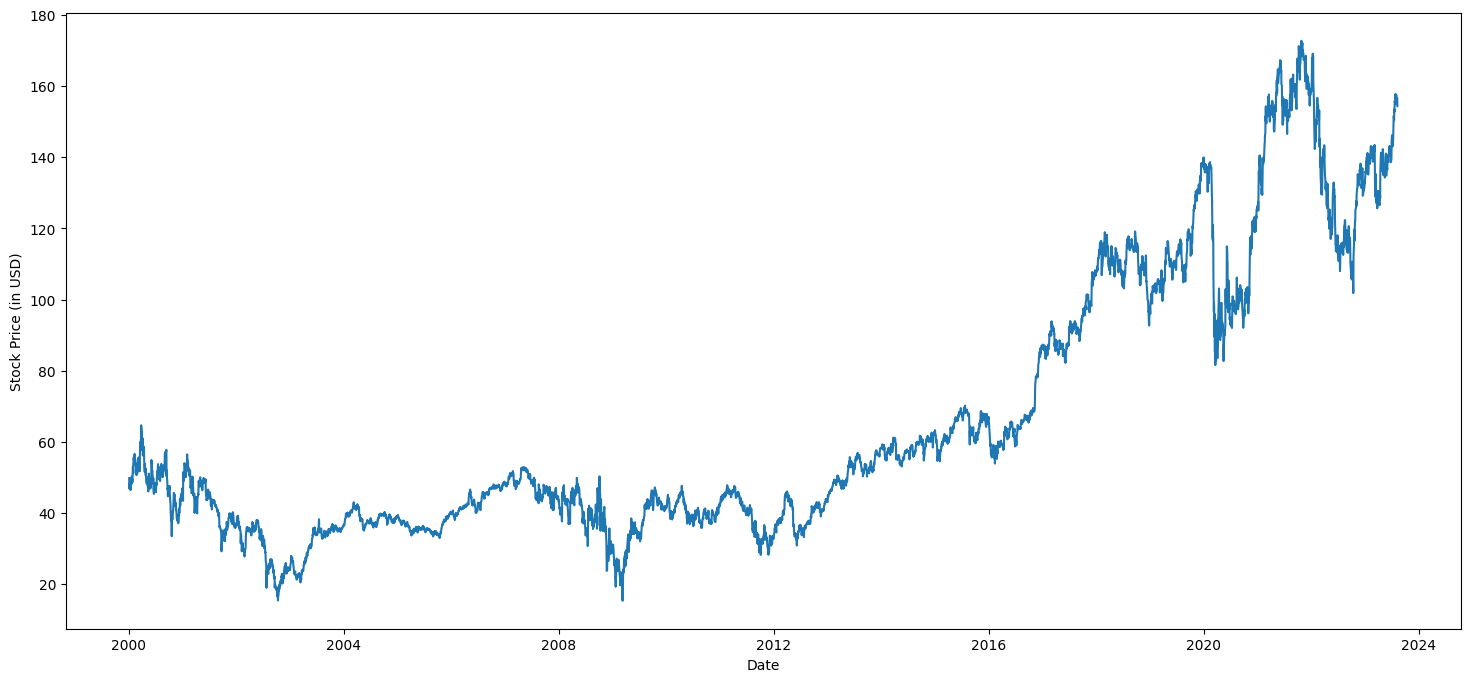

In [5]:
## visualizing data

fig = plt.figure(figsize=(18,8))

plt.plot(data['Open'])
plt.xlabel('Date')
plt.ylabel('Stock Price (in USD)')

plt.show()

In [6]:
## train test split

train = data[data.index < pd.to_datetime('01-01-2018')]  # Adjusted to 90% for training
test = data[data.index >= pd.to_datetime('01-01-2018')]  # Adjusted to 10% for testing
print(train.shape)
print(test.shape)



(4528, 1)
(1409, 1)


In [7]:
## data normalization

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

In [8]:
train[:10]

array([[0.37125211],
       [0.34162806],
       [0.33893497],
       [0.33803728],
       [0.35599126],
       [0.35688895],
       [0.3371396 ],
       [0.33489532],
       [0.34521888],
       [0.3654171 ]])

In [9]:
test[:10]

array([[0.99385974],
       [0.99633743],
       [1.00172362],
       [1.01141878],
       [0.99946143],
       [1.00560168],
       [1.01368097],
       [1.02660779],
       [1.03716476],
       [1.03565663]])

In [10]:
## convert data into proper format

time_steps = 60

def convert(data, time_steps):

    X = list()

    for i in range(time_steps, len(data)):

        obs = data[i-time_steps:i,0].reshape(time_steps) ## observations

        X.append(obs)

    X = np.array(X)

    X = np.reshape(X, (X.shape[0],X.shape[1],1))

    return X

In [11]:
X_train = convert(data=train, time_steps=time_steps)
X_test = convert(data=test, time_steps=time_steps)

In [12]:
print(X_train.shape)
print(X_test.shape)

(4468, 60, 1)
(1349, 60, 1)


In [13]:
## imports

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from keras.optimizers import Adam

In [14]:
model = Sequential() ## initialization

model.add(LSTM(units=3*X_train.shape[1], activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.5)) ## 30% perceptrons turned off at every pass
## output_shape --> (batch_size, 3*X_train.shape[1])
model.add(RepeatVector(n=X_train.shape[1]))
## output_shape --> (batch_size, 3*X_train.shape[1], X_train.shape[1])
model.add(LSTM(units=3*X_train.shape[1], activation='tanh', return_sequences=True))
model.add(Dropout(rate=0.5)) ## 30% perceptrons turned off at every pass
## output_shape --> (batch_size, 3*X_train.shape[1], X_train.shape[1])
model.add(TimeDistributed(Dense(units=X_train.shape[2])))
## output_shape --> (batch_size, 3*X_train.shape[1], 1) --> SAME AS INPUT (AUTOENCODER CONCEPT)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180)               131040    
                                                                 
 dropout (Dropout)           (None, 180)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 60, 180)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 60, 180)           259920    
                                                                 
 dropout_1 (Dropout)         (None, 60, 180)           0         
                                                                 
 time_distributed (TimeDist  (None, 60, 1)             181       
 ributed)                                               

In [15]:
## training

history = model.fit(x=X_train,
                   y=X_train,
                   batch_size=64,
                   epochs=100,
                   validation_split=0.1,
                   shuffle=False)

## notice how X_train is both the input and the target

Epoch 1/100
63/63 [==============================] - 11s 25ms/step - loss: 0.0101 - val_loss: 0.0132
Epoch 2/100
63/63 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0129
Epoch 3/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0053 - val_loss: 0.0179
Epoch 4/100
63/63 [==============================] - 1s 12ms/step - loss: 0.0060 - val_loss: 0.0173
Epoch 5/100
63/63 [==============================] - 1s 13ms/step - loss: 0.0059 - val_loss: 0.0086
Epoch 6/100
63/63 [==============================] - 1s 13ms/step - loss: 0.0064 - val_loss: 0.0085
Epoch 7/100
63/63 [==============================] - 1s 12ms/step - loss: 0.0069 - val_loss: 0.0080
Epoch 8/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 9/100
63/63 [==============================] - 1s 10ms/step - loss: 0.0080 - val_loss: 0.0104
Epoch 10/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0076 - val_loss: 0.010

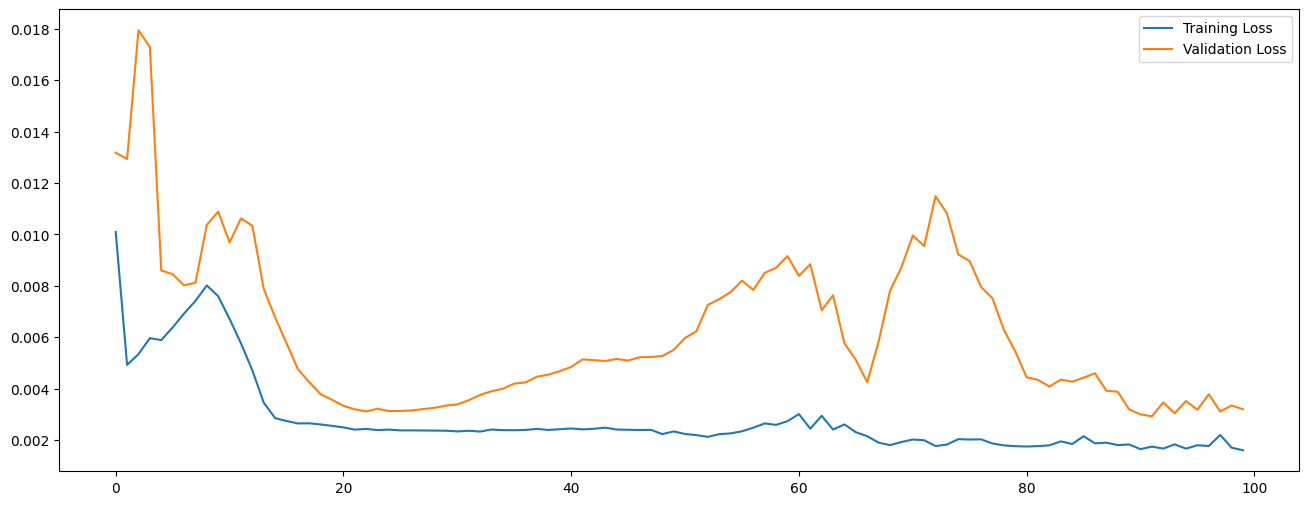

In [16]:
## plot loss over epochs

fig = plt.figure(figsize=(16,6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.show()

140/140 [==============================] - 1s 5ms/step


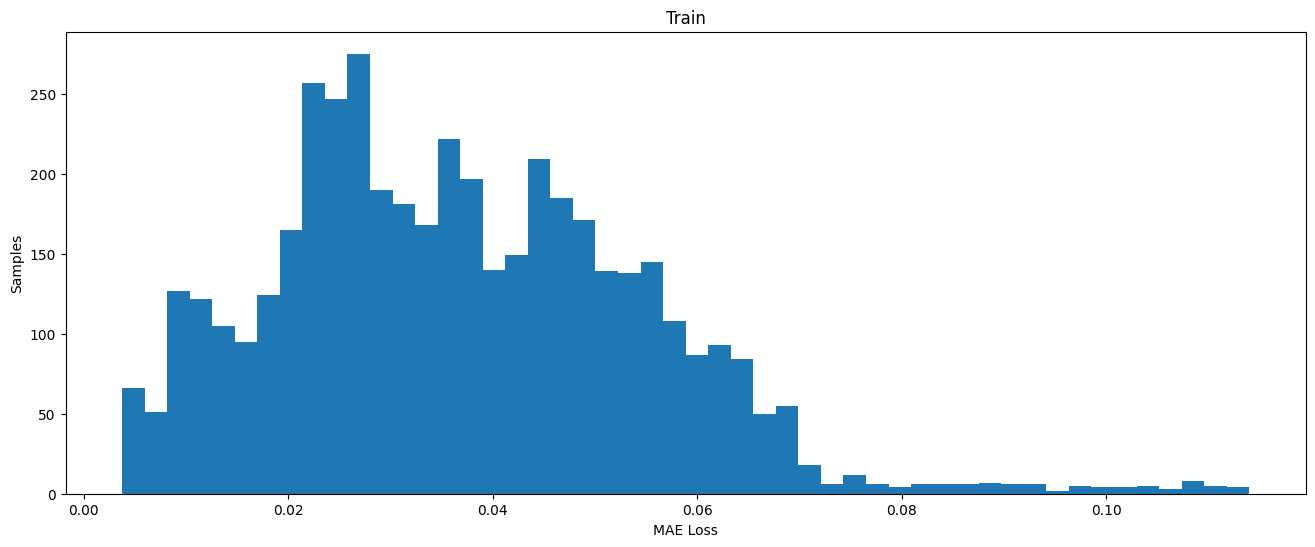

In [17]:
## mean absolute error loss across samples

train_mae_loss = np.mean(np.abs(model.predict(X_train)-X_train), axis=1)

## histogram of mean absolute error

fig = plt.figure(figsize=(16,6))

plt.hist(train_mae_loss, bins=50)
plt.title('Train')
plt.xlabel('MAE Loss')
plt.ylabel('Samples')

plt.show()

In [23]:
threshold = np.max(train_mae_loss) ## this is the max error that our model produced while reconstructing an input
threshold

0.11399580477416772

43/43 [==============================] - 0s 6ms/step


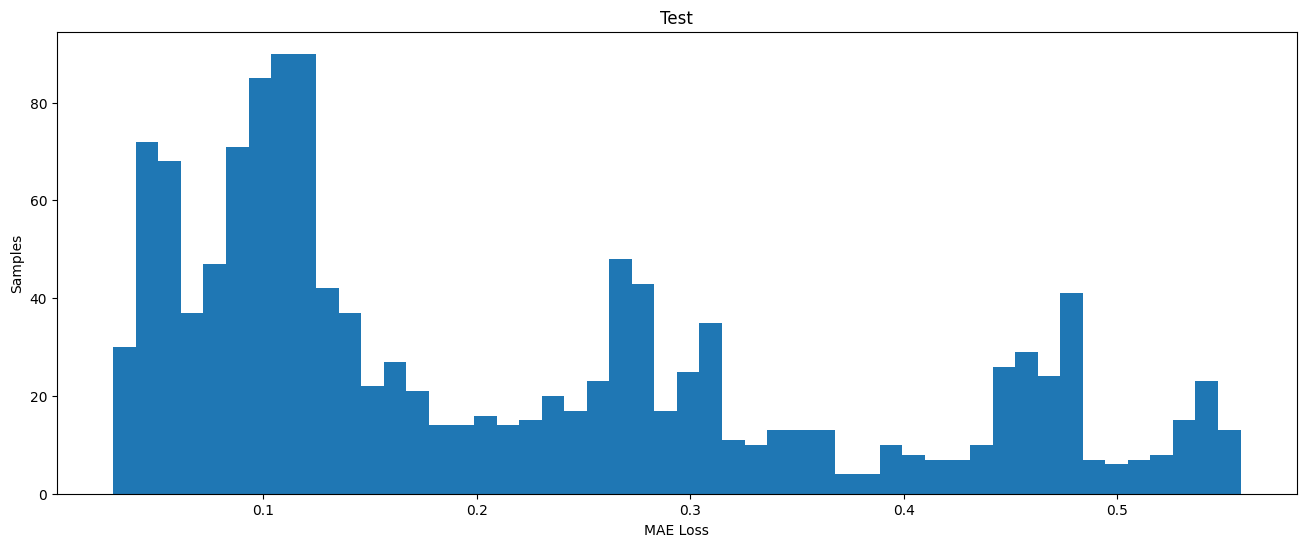

In [18]:
## test mae loss
test_mae_loss = np.mean(np.abs(model.predict(X_test)-X_test), axis=1)

## histogram of mean absolute error

fig = plt.figure(figsize=(16,6))

plt.hist(test_mae_loss, bins=50)
plt.title('Test')
plt.xlabel('MAE Loss')
plt.ylabel('Samples')

plt.show()

In [24]:
anomalies = test_mae_loss > threshold

anomalous_data_indices = [] ## indices of test observations that represent anomalies

for data_idx in range(time_steps - 1, len(test) - time_steps + 1):

    if np.all(anomalies[data_idx - time_steps + 1 : data_idx]):

        anomalous_data_indices.append(data_idx)

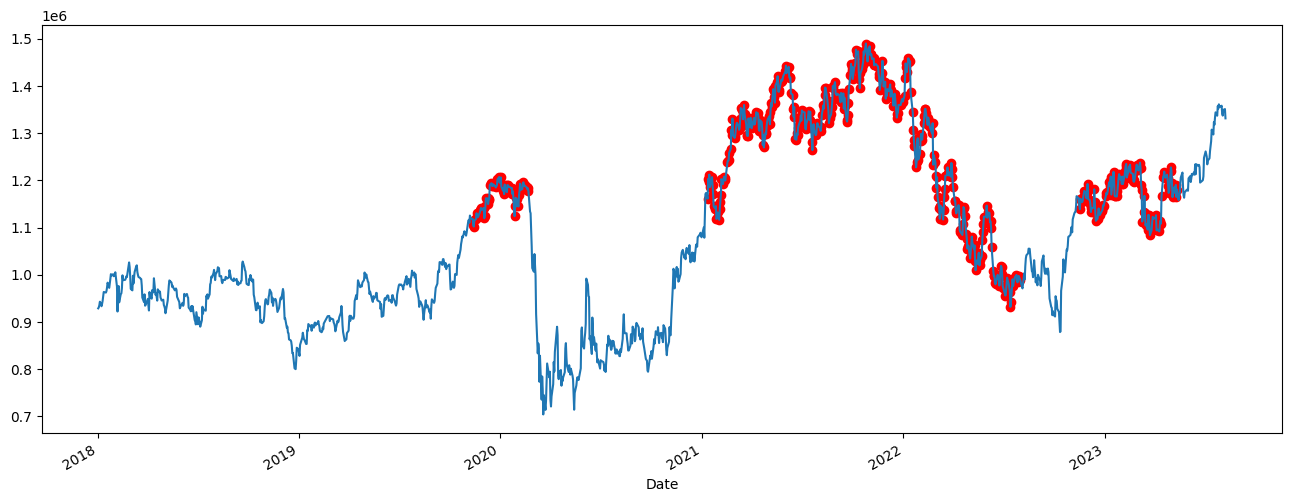

In [25]:
## reconstruction

test = scaler.inverse_transform(test)

reconstruct = pd.DataFrame(data=test, index=data.index[len(data)-len(test):], columns=['Open'])

test_anomalies = reconstruct.iloc[anomalous_data_indices]

fig, ax = plt.subplots(figsize=(16,6))

reconstruct.plot(legend=False, ax=ax)

ax.scatter(x=test_anomalies.index, y=test_anomalies['Open'], color="r")

plt.show()

In [26]:
## save model

from keras.models import save_model
save_model(model, 'LSTM_Autoencoder_timesteps60_epochs100_batchsize64.h5')

<ipython-input-26-7cd85c41f005>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'LSTM_Autoencoder_timesteps60_epochs100_batchsize64.h5')
